In [2]:
#%load_ext jupyter_black

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import optuna

In [4]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [5]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [6]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204674,83.066391,82.026123,82.639412,151892000
2009-09-22 00:00:00-04:00,83.128523,83.353657,82.755886,83.120758,143126700
2009-09-23 00:00:00-04:00,83.314831,83.866019,82.282322,82.429825,225947400
2009-09-24 00:00:00-04:00,82.608389,82.786940,81.164431,81.521538,228636800
2009-09-25 00:00:00-04:00,81.343003,81.793271,80.807339,81.086815,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


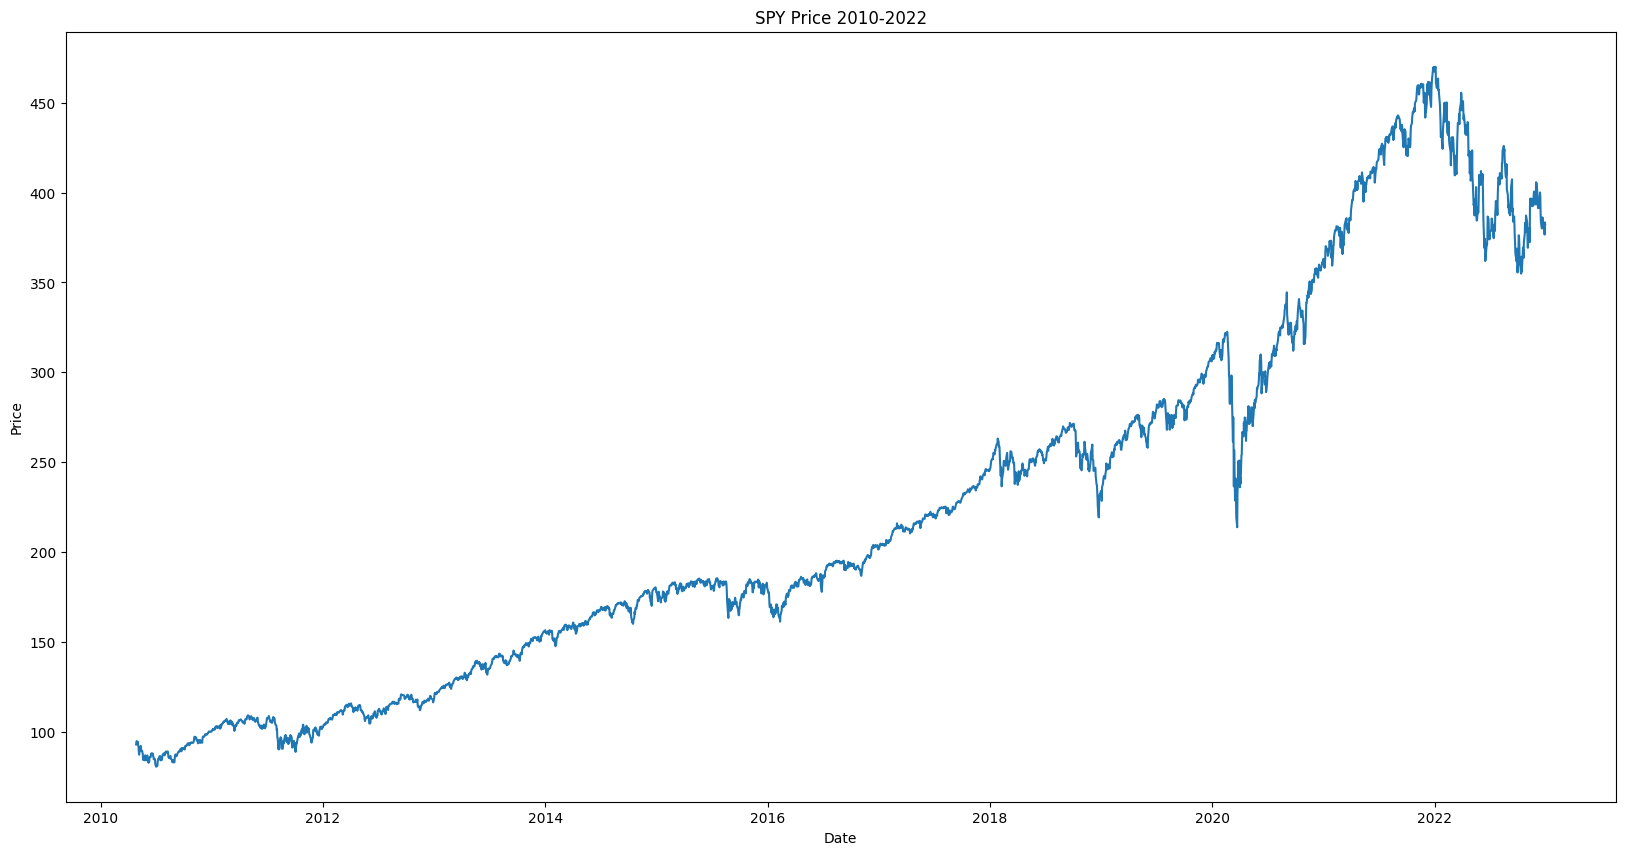

In [7]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [8]:
tn_prices = trendNormalizePrices(prices)
tn_prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-11-02 00:00:00-05:00,-2.497176,-1.503479,-3.312311,-2.349673,254222900
2009-11-03 00:00:00-05:00,-2.646036,-1.823131,-2.801298,-1.939581,228362600
2009-11-04 00:00:00-05:00,-1.110690,-0.474107,-1.778327,-1.568723,247996700
2009-11-05 00:00:00-05:00,-0.968830,-0.021723,-1.139622,-0.045012,180015300
2009-11-06 00:00:00-05:00,-0.467002,0.418004,-0.630029,0.208394,170954100
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,-7.306054,-3.896050,-8.926049,-4.046044,59857300
2022-12-27 00:00:00-05:00,-2.835277,-2.475292,-5.975292,-4.225292,51638200
2022-12-28 00:00:00-05:00,-2.236787,-0.176759,-7.146761,-6.906770,70911500


In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [10]:
prices_and_indicators = tn_prices.copy()

In [ ]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

In [12]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [13]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [14]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

In [ ]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

In [ ]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [17]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [ ]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [ ]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [20]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.758991,-52.957592,55.302662,-24.482019,39.590336,-58.703873,48.985600,-20.819324,41.267189,-58.703873,47.042408,-17.465622,42.725128,41.296127,-14.549746,41.296127,38.372803,37.564983,36.874565,36.290966,35.783165,35.330002,34.931515,34.586704,34.275566,34.000126,33.766720,33.551876,33.348213,33.156738,0
2010-03-17 00:00:00-04:00,37.573975,-51.517811,68.047318,-24.852053,39.431713,-53.441036,54.734329,-21.136576,41.128712,-59.128262,48.482189,-17.742575,42.602657,46.558964,-14.794683,40.871738,43.802238,42.836037,42.011906,41.316257,40.711952,40.173504,39.700630,39.291851,38.923447,38.597652,38.321762,38.068073,37.827801,37.602108,0
2010-03-18 00:00:00-04:00,28.814878,-75.486481,30.960340,-42.370243,31.710533,-78.286583,30.475925,-36.578934,34.252888,-79.147926,24.513523,-31.494221,36.432571,21.713415,-27.134859,20.852072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.401731,-82.355614,19.091681,-57.196537,24.677206,-84.927834,17.840235,-50.645588,27.633684,-86.249168,17.644382,-44.732632,30.235762,15.072163,-39.528477,13.750829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.434649,-56.418522,46.038887,-41.130703,31.283522,-56.808914,46.038887,-37.432957,33.146042,-62.088230,43.581478,-33.707916,34.901855,43.191086,-30.196289,37.911770,28.044504,27.261782,26.587055,26.007507,25.499941,25.047245,24.646458,24.294182,23.976225,23.692047,23.443792,23.215969,23.002810,22.804174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148521,-34.315586,40.716454,42.297043,69.421524,-33.947468,63.216553,38.843040,67.860825,-33.947468,65.684418,35.721657,66.457832,66.052528,32.915665,66.052528,38.982235,41.144901,43.000217,44.605293,46.004486,47.232704,48.317722,49.281864,50.143253,50.916710,51.614456,52.246643,52.821754,53.346928,0
2014-12-26 00:00:00-05:00,72.135742,-34.939743,70.907669,44.271484,70.322220,-32.595577,43.687935,40.644436,68.696327,-32.245914,65.060257,37.392658,67.240913,67.404419,34.481827,67.754089,41.009327,42.018913,42.944439,43.793118,44.571873,45.287209,45.945156,46.551231,47.110458,47.627380,48.578358,49.678761,50.678726,51.590858,0
2014-12-29 00:00:00-05:00,70.688187,-57.836357,50.264736,41.376377,69.128487,-35.885517,63.716160,38.256969,67.680954,-33.477898,42.163643,35.361908,66.357910,64.114487,32.715828,66.522102,6.376227,7.606171,8.725867,9.746984,10.679935,11.534015,12.317490,13.037708,13.701194,14.313730,14.880447,15.405890,15.894088,16.348621,0


In [21]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.521175,-77.039047,23.589186,-14.957648,44.853985,-77.039047,23.589186,-10.292031,46.391724,-77.039047,22.960957,-7.216551,47.422256,22.960957,-5.155488,22.960957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.883121,-95.156906,5.039123,-44.233757,31.124798,-95.247108,4.843093,-37.750404,33.593613,-95.247108,4.843093,-32.812775,35.501469,4.752892,-28.997063,4.752892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230690,-89.828697,11.567293,-51.538620,27.512693,-89.828697,10.501985,-44.974613,30.088877,-89.982582,10.171299,-39.822247,32.133068,10.171299,-35.733864,10.017419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844177,-59.277672,45.624352,-12.311646,44.374142,-60.559933,44.853153,-11.251714,44.875481,-60.559933,40.722328,-10.249038,45.310028,39.440067,-9.379945,39.440067,72.643814,71.864525,71.200279,70.626053,70.123451,69.678734,69.281494,68.923714,68.599152,68.302864,68.030884,67.780006,67.547607,67.331505,0
2015-01-08 00:00:00-05:00,58.889618,-14.809728,96.452911,17.779234,57.928005,-22.655464,86.655022,15.856012,57.213085,-25.090879,85.190269,14.426167,56.644550,77.344536,13.289102,74.909119,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927258,-33.868092,71.318039,1.854515,50.845806,-34.985931,71.318039,1.691616,50.813496,-40.973507,66.131912,1.626987,50.793961,65.014069,1.587920,59.026493,75.165764,75.074013,74.992432,74.919060,74.852386,74.791252,74.734772,74.682251,74.633141,74.587006,74.543495,74.502319,74.463257,74.426094,0
2015-01-12 00:00:00-05:00,44.741199,-48.081348,51.918652,-10.517600,45.298164,-51.856789,51.918652,-9.403671,45.765656,-52.670563,51.918652,-8.468690,46.151566,48.143211,-7.696868,47.329437,54.977192,54.752613,54.550415,54.366665,54.198307,54.042973,53.898792,53.764290,53.638268,53.519760,53.407967,53.302216,53.201939,53.106651,0
2015-01-13 00:00:00-05:00,43.234352,-52.852448,28.193542,-13.531300,43.950325,-52.852448,47.147552,-12.099348,44.541397,-56.280941,47.147552,-10.917208,45.026985,47.147552,-9.946031,43.719059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.824940,-63.247665,32.366772,-20.350119,40.918633,-63.247665,32.366772,-18.162737,41.800560,-63.247665,36.752335,-16.398882,42.518810,36.752335,-14.962381,36.752335,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [23]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445695,-0.529576,0.553027,-0.350318,0.481723,-0.587039,0.489856,-0.323434,0.516424,-0.587039,0.470424,-0.291975,0.548755,0.412961,-0.259987,0.412961,0.383728,0.375650,0.368746,0.362910,0.357832,0.353300,0.349315,0.345867,0.342756,0.340001,0.337667,0.335519,0.333482,0.331567,0.0
2010-03-17 00:00:00-04:00,0.443511,-0.515178,0.680473,-0.355613,0.479793,-0.534410,0.547343,-0.328363,0.514691,-0.591283,0.484822,-0.296605,0.547182,0.465590,-0.264364,0.408717,0.438022,0.428360,0.420119,0.413163,0.407120,0.401735,0.397006,0.392919,0.389234,0.385977,0.383218,0.380681,0.378278,0.376021,0.0
2010-03-18 00:00:00-04:00,0.340122,-0.754865,0.309603,-0.606285,0.385844,-0.782866,0.304759,-0.568264,0.428646,-0.791479,0.245135,-0.526493,0.467934,0.217134,-0.484868,0.208521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252619,-0.823556,0.190917,-0.818437,0.300265,-0.849278,0.178402,-0.786793,0.345812,-0.862492,0.176444,-0.747801,0.388343,0.150722,-0.706328,0.137508,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347437,-0.564185,0.460389,-0.588548,0.380648,-0.568089,0.460389,-0.581531,0.414795,-0.620882,0.435815,-0.563499,0.448274,0.431911,-0.539572,0.379118,0.280445,0.272618,0.265871,0.260075,0.254999,0.250472,0.246465,0.242942,0.239762,0.236920,0.234438,0.232160,0.230028,0.228042,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839815,-0.343156,0.407165,0.605237,0.844700,-0.339475,0.632166,0.603438,0.849221,-0.339475,0.656844,0.597163,0.853574,0.660525,0.588165,0.660525,0.389822,0.411449,0.430002,0.446053,0.460045,0.472327,0.483177,0.492819,0.501433,0.509167,0.516145,0.522466,0.528218,0.533469,0.0
2014-12-26 00:00:00-05:00,0.851468,-0.349397,0.709077,0.633490,0.855660,-0.325956,0.436879,0.631423,0.859677,-0.322459,0.650603,0.625098,0.863632,0.674044,0.616150,0.677541,0.410093,0.420189,0.429444,0.437931,0.445719,0.452872,0.459452,0.465512,0.471105,0.476274,0.485784,0.496788,0.506787,0.515909,0.0
2014-12-29 00:00:00-05:00,0.834381,-0.578364,0.502647,0.592063,0.841135,-0.358855,0.637162,0.594333,0.846971,-0.334779,0.421636,0.591149,0.852291,0.641145,0.584594,0.665221,0.063762,0.076062,0.087259,0.097470,0.106799,0.115340,0.123175,0.130377,0.137012,0.143137,0.148804,0.154059,0.158941,0.163486,0.0


In [24]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501907,-0.770390,0.235892,-0.214032,0.545770,-0.770390,0.235892,-0.159890,0.580554,-0.770390,0.229610,-0.120640,0.609084,0.229610,-0.092123,0.229610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329124,-0.951569,0.050391,-0.632950,0.378717,-0.952471,0.048431,-0.586463,0.420396,-0.952471,0.048431,-0.548535,0.455975,0.047529,-0.518144,0.047529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286012,-0.898287,0.115673,-0.737477,0.334766,-0.898287,0.105020,-0.698693,0.376537,-0.899826,0.101713,-0.665713,0.412712,0.101713,-0.638522,0.100174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517523,-0.592777,0.456244,-0.176170,0.539931,-0.605599,0.448532,-0.174799,0.561579,-0.605599,0.407223,-0.171334,0.581955,0.394401,-0.167609,0.394401,0.726438,0.718645,0.712003,0.706261,0.701235,0.696787,0.692815,0.689237,0.685992,0.683029,0.680309,0.677800,0.675476,0.673315,0.0
2015-01-08 00:00:00-05:00,0.695115,-0.148097,0.964529,0.254407,0.704851,-0.226555,0.866550,0.246328,0.715974,-0.250909,0.851903,0.241164,0.727534,0.773445,0.237461,0.749091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601129,-0.338681,0.713180,0.026537,0.618676,-0.349859,0.713180,0.026280,0.635888,-0.409735,0.661319,0.027199,0.652390,0.650141,0.028374,0.590265,0.751658,0.750740,0.749924,0.749191,0.748524,0.747913,0.747348,0.746823,0.746331,0.745870,0.745435,0.745023,0.744633,0.744261,0.0
2015-01-12 00:00:00-05:00,0.528111,-0.480813,0.519187,-0.150499,0.551174,-0.518568,0.519187,-0.146089,0.572719,-0.526706,0.519187,-0.141572,0.592763,0.481432,-0.137534,0.473294,0.549772,0.547526,0.545504,0.543667,0.541983,0.540430,0.538988,0.537643,0.536383,0.535198,0.534080,0.533022,0.532019,0.531067,0.0
2015-01-13 00:00:00-05:00,0.510325,-0.528524,0.281935,-0.193622,0.534774,-0.528524,0.471476,-0.187967,0.557398,-0.562809,0.471476,-0.182504,0.578319,0.471476,-0.177724,0.437191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470081,-0.632477,0.323668,-0.291194,0.497886,-0.632477,0.323668,-0.282163,0.523099,-0.632477,0.367523,-0.274142,0.546105,0.367523,-0.267360,0.367523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [25]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
def create_model_MLP(trial=None, activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [ ]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [102]:
df = datas[0][0].drop(columns=["Label"])
df_matrix = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df.shape[0] - 29):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30))
    df_matrix.iloc[i, 0] = matrix

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
set_random_seed()
start_time = time.time()

def objective(trial):
    activation_func = trial.suggest_categorical(name="activation_func", choices = ["relu", "selu", "swish"])
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical("optimizer_algorithm", ["adam", "adadelta", "rmsprop"])
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    #epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1,1e-2,1e-3,1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(monitor='f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
        mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='f1_score', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='max')

        val_split_point = int(0.5*len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(X_train, y_train, batch_size=batch, 
                                epochs=1, verbose=0, callbacks=[es, mcp], 
                                class_weight={0:1, 1:10, 2:10})
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    return np.mean(f1_scores)

study = optuna.create_study(study_name="MLP_Bayesian_Optimization", direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print('Best F1 Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>